In [10]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
import numpy as np
import pandas as pd
import glob
import optuna

In [85]:
real_df = pd.read_csv("Real_Datasets/Adult.csv")
small_df = real_df.sample(n=2000, random_state=42)
small_df.to_csv("Real_Datasets/Adult_small.csv", index=False)

In [127]:
num_exp = 10
dataset = "Adult"
real_path = "Real_Datasets/Adult_small.csv"
fake_path = "Fake_Datasets/Adult_fake.csv"
fake_best_path = "Fake_Datasets/Adult_fake_best.csv"
categoricals = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'native-country', 'income'
    ]

In [87]:
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = categoricals, 
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 general_columns = ["age"],
                 non_categorical_columns = [],
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'},
                 epochs=10,
                 batch_size=64) 

In [ ]:
synthesizer.fit()
syn = synthesizer.generate_samples()
syn.to_csv(fake_path, index= False)

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


Finished training in 53.69700813293457  seconds.


In [89]:
classifiers_list = ["lr","dt","rf","mlp"]
result_mat = get_utility_metrics(real_path,[fake_path],"MinMax",classifiers_list, test_ratio = 0.20)

result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,1.00,0.037775,0.114794
dt,12.75,0.211954,0.202820
rf,7.50,0.107633,0.161664
mlp,4.25,0.110353,0.161327


In [95]:
stat_res = stat_sim(real_path,fake_path,categoricals)


stat_columns = ["Average WD (Continuous Columns)","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns),Average JSD (Categorical Columns),Correlation Distance
0,0.067508,0.139739,1.846286


In [96]:
priv_res = privacy_metrics(real_path,fake_path)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,1.009521,0.755341,1.105118,0.678026,0.573052,0.609349


In [98]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    class_dim = trial.suggest_categorical("class_dim", [(64,64), (128,128)])
    random_dim = trial.suggest_int("random_dim", 64, 200)
    num_channels = trial.suggest_categorical("num_channels", [32, 64, 128])

    synthesizer = CTABGAN(
        raw_csv_path=real_path,
        test_ratio=0.20,
        categorical_columns = categoricals, 
        log_columns = [],
        mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
        general_columns = ["age"],
        non_categorical_columns = [],
        integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
        problem_type= {"Classification": 'income'},
        epochs=10,
        batch_size=batch_size,
        class_dim=class_dim,
        random_dim=random_dim,
        num_channels=num_channels
    )

    synthesizer.fit()
    syn = synthesizer.generate_samples()

    temp_path = "tmp_synth.csv"
    syn.to_csv(temp_path, index=False)

    util_scores = get_utility_metrics(real_path, [temp_path], "MinMax", ["lr"])[0]
    stat_scores = stat_sim(real_path, temp_path, categoricals)

    auc, f1 = util_scores[1], util_scores[2]
    jsd = stat_scores[1]
    corr = stat_scores[2]
    score = auc + f1 - 0.5 * jsd - 0.25 * corr

    return score

In [107]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=3)
study = optuna.create_study(direction="maximize", study_name="ctabgan_optimization", pruner=pruner)

[I 2025-06-01 20:17:30,278] A new study created in memory with name: ctabgan_optimization


In [108]:
study.optimize(objective, n_trials=15)

100%|██████████| 10/10 [02:21<00:00, 14.15s/it]


Finished training in 141.839998960495  seconds.


[I 2025-06-01 20:19:56,110] Trial 0 finished with value: -0.14093033034984231 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 138, 'num_channels': 128}. Best is trial 0 with value: -0.14093033034984231.
100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


Finished training in 19.440577030181885  seconds.


[I 2025-06-01 20:20:16,165] Trial 1 finished with value: -0.1673599238410513 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 167, 'num_channels': 32}. Best is trial 0 with value: -0.14093033034984231.
100%|██████████| 10/10 [02:57<00:00, 17.71s/it]


Finished training in 177.48773622512817  seconds.


[I 2025-06-01 20:23:16,255] Trial 2 finished with value: -0.1835203894915477 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 183, 'num_channels': 128}. Best is trial 0 with value: -0.14093033034984231.
100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Finished training in 19.514999866485596  seconds.


[I 2025-06-01 20:23:36,332] Trial 3 finished with value: -0.0405777371783852 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 92, 'num_channels': 32}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [02:16<00:00, 13.65s/it]


Finished training in 136.78836750984192  seconds.


[I 2025-06-01 20:25:55,977] Trial 4 finished with value: -0.07820661859781097 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 168, 'num_channels': 128}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


Finished training in 20.00166606903076  seconds.


[I 2025-06-01 20:26:16,547] Trial 5 finished with value: -0.13531769495355161 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 102, 'num_channels': 32}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Finished training in 47.3115770816803  seconds.


[I 2025-06-01 20:27:04,848] Trial 6 finished with value: -0.42842930327843737 and parameters: {'batch_size': 128, 'class_dim': (128, 128), 'random_dim': 140, 'num_channels': 64}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


Finished training in 147.2064185142517  seconds.


[I 2025-06-01 20:29:34,519] Trial 7 finished with value: -0.30276660263846794 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 168, 'num_channels': 128}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [02:20<00:00, 14.02s/it]


Finished training in 140.54357051849365  seconds.


[I 2025-06-01 20:31:57,560] Trial 8 finished with value: -0.5022907030092768 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 178, 'num_channels': 128}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Finished training in 18.82416033744812  seconds.


[I 2025-06-01 20:32:16,950] Trial 9 finished with value: -0.30943707013835153 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 121, 'num_channels': 32}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


Finished training in 52.28722262382507  seconds.


[I 2025-06-01 20:33:10,142] Trial 10 finished with value: -0.12168512917406249 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 68, 'num_channels': 64}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Finished training in 17.624722957611084  seconds.


[I 2025-06-01 20:33:28,344] Trial 11 finished with value: -0.3828024065650173 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 72, 'num_channels': 32}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [02:21<00:00, 14.13s/it]


Finished training in 141.6318428516388  seconds.


[I 2025-06-01 20:35:53,122] Trial 12 finished with value: -0.048095744762779225 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 97, 'num_channels': 128}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Finished training in 20.11404800415039  seconds.


[I 2025-06-01 20:36:13,812] Trial 13 finished with value: -0.0913357057441736 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 102, 'num_channels': 32}. Best is trial 3 with value: -0.0405777371783852.
100%|██████████| 10/10 [00:43<00:00,  4.31s/it]


Finished training in 43.46430730819702  seconds.


[I 2025-06-01 20:36:58,181] Trial 14 finished with value: -0.38135930118364325 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 92, 'num_channels': 64}. Best is trial 3 with value: -0.0405777371783852.


In [110]:
print("Best parameters:")
print(study.best_trial.params)

print("\nBest score:", study.best_value)

Best parameters:
{'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 92, 'num_channels': 32}

Best score: -0.0405777371783852


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

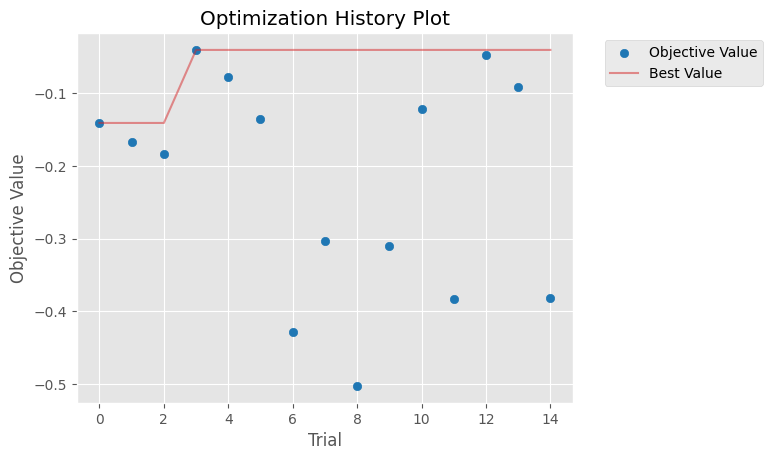

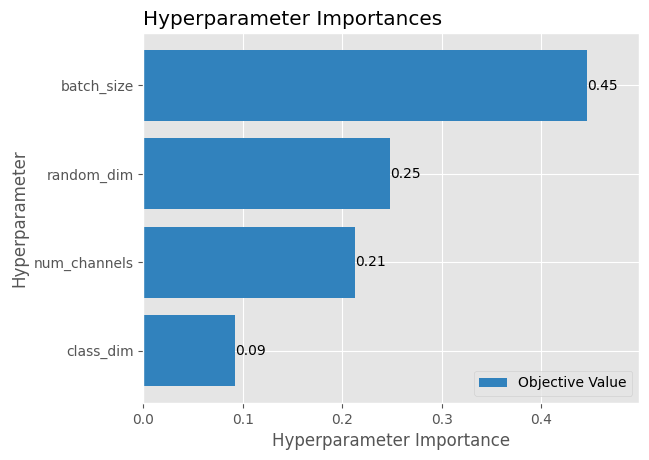

In [111]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
plot_optimization_history(study)
plot_param_importances(study)

In [ ]:
def objective2(trial):
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 96])
    class_dim = trial.suggest_categorical("class_dim", [(64, 64), (64, 128)])
    random_dim = trial.suggest_int("random_dim", 80, 130)
    num_channels = trial.suggest_categorical("num_channels", [16, 32, 64])

    synthesizer = CTABGAN(
        raw_csv_path=real_path,
        test_ratio=0.20,
        categorical_columns = categoricals, 
        log_columns = [],
        mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
        general_columns = ["age"],
        non_categorical_columns = [],
        integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
        problem_type= {"Classification": 'income'},
        epochs=10,
        batch_size=batch_size,
        class_dim=class_dim,
        random_dim=random_dim,
        num_channels=num_channels
    )

    synthesizer.fit()
    syn = synthesizer.generate_samples()

    temp_path = "tmp_synth.csv"
    syn.to_csv(temp_path, index=False)

    util_scores = get_utility_metrics(real_path, [temp_path], "MinMax", ["lr"])[0]
    stat_scores = stat_sim(real_path, temp_path, categoricals)

    auc, f1 = util_scores[1], util_scores[2]
    jsd = stat_scores[1]
    corr = stat_scores[2]
    score = auc + f1 - 0.5 * jsd - 0.25 * corr

    return score

In [113]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=3)
study2 = optuna.create_study(direction="maximize", study_name="ctabgan_optimization2", pruner=pruner)

[I 2025-06-01 20:39:44,981] A new study created in memory with name: ctabgan_optimization2


In [114]:
study2.optimize(objective, n_trials=30)

100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Finished training in 48.20345759391785  seconds.


[I 2025-06-01 20:40:36,053] Trial 0 finished with value: -0.4307945365891002 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 78, 'num_channels': 64}. Best is trial 0 with value: -0.4307945365891002.
100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Finished training in 18.512322664260864  seconds.


[I 2025-06-01 20:40:55,208] Trial 1 finished with value: -0.026974197350593476 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 154, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Finished training in 18.432236671447754  seconds.


[I 2025-06-01 20:41:14,263] Trial 2 finished with value: -0.11275966264514214 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 119, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Finished training in 20.716065168380737  seconds.


[I 2025-06-01 20:41:35,581] Trial 3 finished with value: -0.21400579878198367 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 79, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


Finished training in 54.555869579315186  seconds.


[I 2025-06-01 20:42:31,063] Trial 4 finished with value: -0.050335470842684193 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 123, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [02:32<00:00, 15.27s/it]


Finished training in 153.04107666015625  seconds.


[I 2025-06-01 20:45:07,155] Trial 5 finished with value: -0.28719201626109014 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 78, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [03:00<00:00, 18.03s/it]


Finished training in 180.61811423301697  seconds.


[I 2025-06-01 20:48:10,744] Trial 6 finished with value: -0.32814627042624633 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 99, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Finished training in 47.98901057243347  seconds.


[I 2025-06-01 20:48:59,755] Trial 7 finished with value: -0.341235795828004 and parameters: {'batch_size': 128, 'class_dim': (128, 128), 'random_dim': 102, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [02:58<00:00, 17.81s/it]


Finished training in 178.4456226825714  seconds.


[I 2025-06-01 20:52:01,189] Trial 8 finished with value: -0.22119342927694358 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 79, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [03:00<00:00, 18.06s/it]


Finished training in 180.9503607749939  seconds.


[I 2025-06-01 20:55:04,923] Trial 9 finished with value: -0.0550012999318108 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 177, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Finished training in 18.54699420928955  seconds.


[I 2025-06-01 20:55:24,077] Trial 10 finished with value: -0.1704821852263737 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 165, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Finished training in 45.57856583595276  seconds.


[I 2025-06-01 20:56:10,595] Trial 11 finished with value: -0.3321125670704944 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 151, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Finished training in 55.39515256881714  seconds.


[I 2025-06-01 20:57:06,951] Trial 12 finished with value: -0.15074440191570887 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 139, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


Finished training in 18.351842403411865  seconds.


[I 2025-06-01 20:57:25,906] Trial 13 finished with value: -0.32915793307111224 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 122, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Finished training in 19.799244165420532  seconds.


[I 2025-06-01 20:57:46,354] Trial 14 finished with value: -0.35989369617159805 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 199, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


Finished training in 55.157644271850586  seconds.


[I 2025-06-01 20:58:42,620] Trial 15 finished with value: -0.4782899809244556 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 149, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Finished training in 46.0316743850708  seconds.


[I 2025-06-01 20:59:29,608] Trial 16 finished with value: -0.0835178250768921 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 175, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Finished training in 18.278084993362427  seconds.


[I 2025-06-01 20:59:48,485] Trial 17 finished with value: -0.47827834980802053 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 108, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Finished training in 21.02958345413208  seconds.


[I 2025-06-01 21:00:10,121] Trial 18 finished with value: -0.05911844859197868 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 129, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Finished training in 48.92745614051819  seconds.


[I 2025-06-01 21:01:00,015] Trial 19 finished with value: -0.28326589116494 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 157, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Finished training in 21.218558073043823  seconds.


[I 2025-06-01 21:01:21,840] Trial 20 finished with value: -0.2418969071703534 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 138, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [03:00<00:00, 18.09s/it]


Finished training in 181.27293992042542  seconds.


[I 2025-06-01 21:04:25,935] Trial 21 finished with value: -0.2679751695381485 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 186, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [03:03<00:00, 18.38s/it]


Finished training in 184.18120908737183  seconds.


[I 2025-06-01 21:07:33,137] Trial 22 finished with value: -0.12075782876197555 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 173, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [03:05<00:00, 18.50s/it]


Finished training in 185.40451312065125  seconds.


[I 2025-06-01 21:10:41,719] Trial 23 finished with value: -0.15491996904106142 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 187, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [02:55<00:00, 17.53s/it]


Finished training in 175.6647880077362  seconds.


[I 2025-06-01 21:13:40,409] Trial 24 finished with value: -0.4930906161365973 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 161, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [02:26<00:00, 14.65s/it]


Finished training in 146.8946249485016  seconds.


[I 2025-06-01 21:16:09,973] Trial 25 finished with value: -0.3539220162873542 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 147, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


Finished training in 56.39476227760315  seconds.


[I 2025-06-01 21:17:07,363] Trial 26 finished with value: -0.2662679827500312 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 174, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [02:55<00:00, 17.52s/it]


Finished training in 175.59121131896973  seconds.


[I 2025-06-01 21:20:05,953] Trial 27 finished with value: -0.37218669625658385 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 198, 'num_channels': 128}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Finished training in 19.543652772903442  seconds.


[I 2025-06-01 21:20:26,117] Trial 28 finished with value: -0.18783700301576223 and parameters: {'batch_size': 128, 'class_dim': (128, 128), 'random_dim': 117, 'num_channels': 32}. Best is trial 1 with value: -0.026974197350593476.
100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


Finished training in 44.972357511520386  seconds.


[I 2025-06-01 21:21:12,025] Trial 29 finished with value: -0.14884995250992977 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 90, 'num_channels': 64}. Best is trial 1 with value: -0.026974197350593476.


In [116]:
print("Best parameters:")
print(study2.best_trial.params)

print("\nBest score:", study2.best_value)

Best parameters:
{'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 154, 'num_channels': 32}

Best score: -0.026974197350593476


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

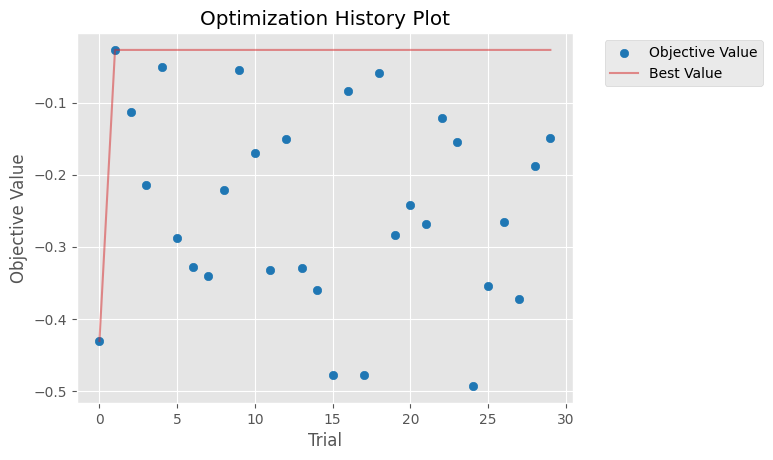

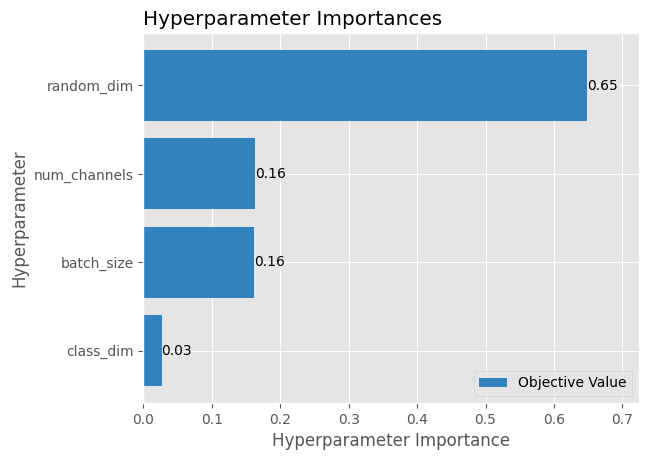

In [117]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
plot_optimization_history(study2)
plot_param_importances(study2)

In [130]:
final_model = CTABGAN(
    raw_csv_path=real_path,
    categorical_columns=categoricals,
    log_columns=[],
    mixed_columns={'capital-loss': [0.0], 'capital-gain': [0.0]},
    general_columns=["age"],
    non_categorical_columns=[],
    integer_columns=['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'],
    problem_type={"Classification": 'income'},
    epochs=10,
    **study2.best_trial.params
)

final_model.fit()
final_samples = final_model.generate_samples()
final_samples.to_csv(fake_best_path, index= False)

100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Finished training in 17.867844104766846  seconds.


In [131]:
classifiers_list = ["lr","dt","rf","mlp"]
result_mat = get_utility_metrics(real_path,[fake_best_path],"MinMax",classifiers_list, test_ratio = 0.20)

result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,1.25,0.480605,0.169452
dt,20.50,0.235708,0.235016
rf,13.75,0.538147,0.366801
mlp,5.00,0.559062,0.262217


In [132]:
stat_res = stat_sim(real_path,fake_best_path,categoricals)


stat_columns = ["Average WD (Continuous Columns)","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns),Average JSD (Categorical Columns),Correlation Distance
0,0.057081,0.190079,2.518523


In [133]:
priv_res = privacy_metrics(real_path,fake_best_path)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,1.318168,0.755341,1.321808,0.671103,0.573052,0.666624
